## DCGAN

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , LeakyReLU , Layer , Conv2D , BatchNormalization , Conv2DTranspose , Flatten

In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Generator

In [22]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

In [23]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

In [24]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

In [25]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

# Losses

In [26]:
def discriminator_loss(d_real, d_fake):
    '''
    Discriminator는 
    실제 이미지는 1과 비교해서 Real_image의 Feature들을 1과 가깝게 근사시킬려고 하고
    가짜 이미지는 0과 비교해서 Fake_image의 Feature들을 0과 가깝게 근사시킬려고 한다.
    '''
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    '''
    Generator에서는
    가짜 이미지는 1에 근사시키게 Feature들을 학습한다.
    '''
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## training Step

In [27]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        '''
        가짜 정규분포 Z를 만들어
        Generator에 투입해 G(Z) -> Fake Image를 만들고
        
        Discriminator(G(Z)) -> D_fake Image
                     + 
        Discriminator(Real_image) -> D_real Image 
        
        =>>> Loss(D_fake  + D_real)를 통해서 Discriminator를 Optimizing하고
        ->> Loss(Generator)를 통해서  Generator를 Optimizing한다.
        
        '''
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(Generator , to_file = 'model_g.png')
plot_model(Discriminator , to_file = 'model_d.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Training Loop

2022-05-19 03:21:39.234868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-19 03:21:40.549048: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-19 03:21:41.622259: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


epoch: 1, d_loss: 1.0022051334381104, g_loss: 0.9741671085357666


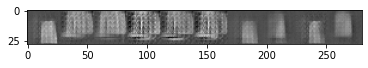

epoch: 2, d_loss: 1.1232672929763794, g_loss: 0.8899455070495605
epoch: 3, d_loss: 1.1293716430664062, g_loss: 0.8957821130752563
epoch: 4, d_loss: 1.1370946168899536, g_loss: 0.8978390693664551
epoch: 5, d_loss: 1.1390055418014526, g_loss: 0.9036460518836975
epoch: 6, d_loss: 1.1440564393997192, g_loss: 0.9076539874076843
epoch: 7, d_loss: 1.1499065160751343, g_loss: 0.9073107838630676
epoch: 8, d_loss: 1.1586852073669434, g_loss: 0.9057252407073975
epoch: 9, d_loss: 1.1624224185943604, g_loss: 0.9069768786430359
epoch: 10, d_loss: 1.1586211919784546, g_loss: 0.9132968783378601
epoch: 11, d_loss: 1.1583234071731567, g_loss: 0.9181537628173828


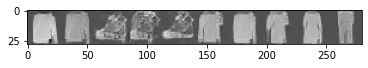

epoch: 12, d_loss: 1.1619486808776855, g_loss: 0.9197399020195007
epoch: 13, d_loss: 1.1476409435272217, g_loss: 0.9350547790527344
epoch: 14, d_loss: 1.1634643077850342, g_loss: 0.9262799620628357
epoch: 15, d_loss: 1.1637314558029175, g_loss: 0.930007815361023
epoch: 16, d_loss: 1.1558945178985596, g_loss: 0.9369842410087585
epoch: 17, d_loss: 1.1616153717041016, g_loss: 0.9342889785766602
epoch: 18, d_loss: 1.1623774766921997, g_loss: 0.9383260607719421
epoch: 19, d_loss: 1.1606013774871826, g_loss: 0.9413222074508667
epoch: 20, d_loss: 1.155340313911438, g_loss: 0.9497717618942261
epoch: 21, d_loss: 1.1603102684020996, g_loss: 0.94594806432724


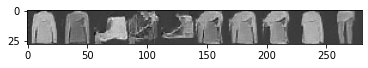

epoch: 22, d_loss: 1.165873408317566, g_loss: 0.9460383653640747
epoch: 23, d_loss: 1.1624338626861572, g_loss: 0.950324296951294
epoch: 24, d_loss: 1.1619983911514282, g_loss: 0.9497722387313843
epoch: 25, d_loss: 1.1626394987106323, g_loss: 0.9506629109382629
epoch: 26, d_loss: 1.1479333639144897, g_loss: 0.9674665331840515
epoch: 27, d_loss: 1.1392443180084229, g_loss: 0.9751376509666443
epoch: 28, d_loss: 1.1449801921844482, g_loss: 0.9743828177452087
epoch: 29, d_loss: 1.1449534893035889, g_loss: 0.9777352809906006
epoch: 30, d_loss: 1.1507245302200317, g_loss: 0.9738278388977051
epoch: 31, d_loss: 1.1608206033706665, g_loss: 0.9695712924003601


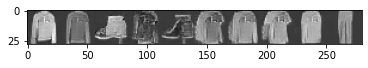

epoch: 32, d_loss: 1.1530702114105225, g_loss: 0.9770317077636719
epoch: 33, d_loss: 1.141180157661438, g_loss: 0.9853901267051697
epoch: 34, d_loss: 1.1557220220565796, g_loss: 0.9751256108283997
epoch: 35, d_loss: 1.1594091653823853, g_loss: 0.9756291508674622
epoch: 36, d_loss: 1.1621242761611938, g_loss: 0.9728747606277466
epoch: 37, d_loss: 1.1614830493927002, g_loss: 0.9760190844535828
epoch: 38, d_loss: 1.1504290103912354, g_loss: 0.9848530888557434
epoch: 39, d_loss: 1.145912528038025, g_loss: 0.990043044090271



KeyboardInterrupt



In [8]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()